<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Stacked Charts**


Estimated time needed: **45** minutes


In this lab, you will focus on visualizing data specifically using stacked charts. You will use SQL queries to extract the necessary data and apply stacked charts to analyze the composition and comparison within the data.


## Objectives


In this lab, you will perform the following:


- Visualize the composition of data using stacked charts.

- Compare multiple variables across different categories using stacked charts.

- Analyze trends within stacked chart visualizations.


## Setup: Downloading and Loading the Data
**Install the libraries**


In [1]:
!pip install pandas
!pip install matplotlib

**Download and Load the Data**


To start, download and load the dataset into a `pandas` DataFrame.



### Step 1: Download the dataset


In [9]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv"

### Step 2: Import necessary libraries and load the dataset


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Load the data


In [12]:
df = pd.read_csv(url)

### Display the first few rows of the data to understand its structure


In [13]:
df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


### Task 1: Stacked Chart for Composition of Job Satisfaction Across Age Groups


##### 1. Stacked Chart of Median `JobSatPoints_6` and `JobSatPoints_7` for Different Age Groups


Visualize the composition of job satisfaction scores (`JobSatPoints_6` and `JobSatPoints_7`) across various age groups. This will help in understanding the breakdown of satisfaction levels across different demographics.



C:\Users\liyana_bh\AppData\Local\Temp\ipykernel_17932\3484458578.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist["pct"] = dist["count"] / dist.groupby(["Metric", "AgeGroup"])["count"].transform("sum") * 100


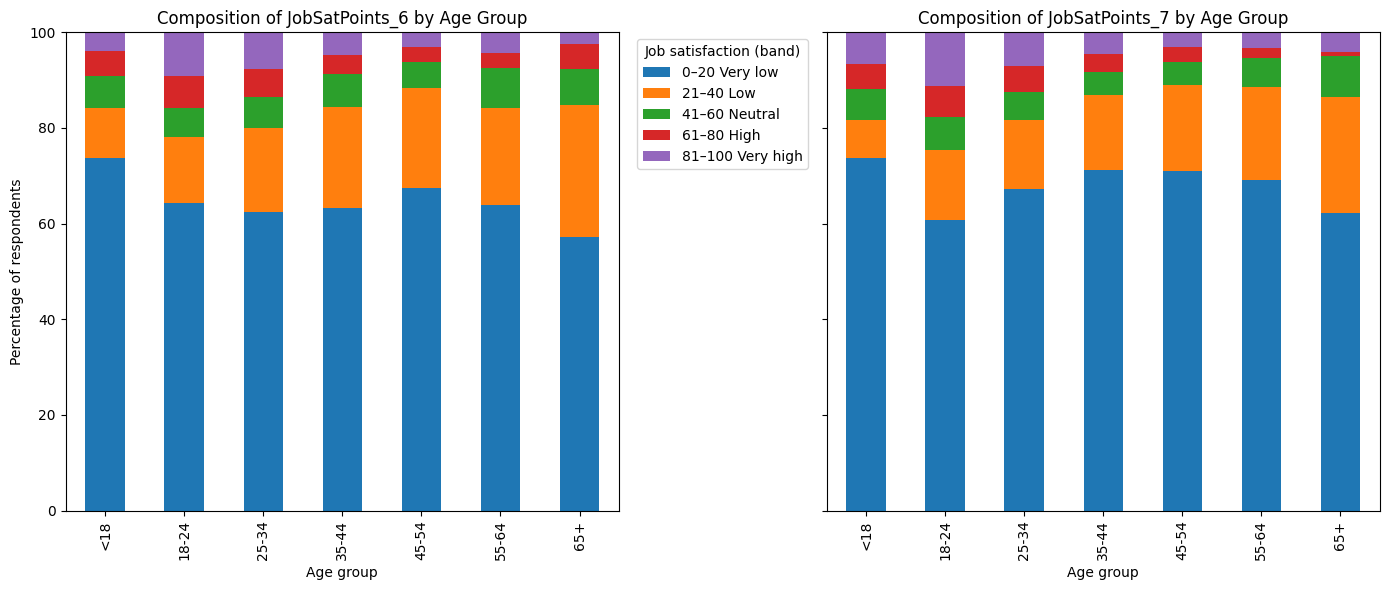

In [23]:
# Assumes: `df` already loaded and pandas/matplotlib imported.

import numpy as np
import re

# --- 1) Age → groups (kept here so you can run end-to-end) -------------------
age_bins   = [0, 18, 25, 35, 45, 55, 65, 120]
age_labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

def parse_age_to_number(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    v = pd.to_numeric(s, errors="coerce")
    if pd.notna(v): return float(v)
    m = re.search(r'(\d+)\D+(\d+)', s)  # ranges like 18-24
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0
    if "under" in s and "18" in s: return 16.0
    if ("65" in s and "older" in s) or "65+" in s: return 67.0
    return np.nan

df["Age_num"]  = df["Age"].apply(parse_age_to_number)
df["AgeGroup"] = pd.cut(df["Age_num"], bins=age_bins, labels=age_labels, right=False, include_lowest=True)

# --- 2) Tidy the two satisfaction metrics -----------------------------------
need_cols = ["AgeGroup", "JobSatPoints_6", "JobSatPoints_7"]
for c in need_cols[1:]:
    if c not in df.columns:
        raise KeyError(f"Column '{c}' not found.")

tidy = df[need_cols].melt(
    id_vars="AgeGroup",
    value_vars=["JobSatPoints_6", "JobSatPoints_7"],
    var_name="Metric", value_name="Score"
)
tidy["Score"] = pd.to_numeric(tidy["Score"], errors="coerce")
tidy = tidy.dropna(subset=["AgeGroup", "Score"]).copy()
tidy["AgeGroup"] = pd.Categorical(tidy["AgeGroup"], categories=age_labels, ordered=True)

# --- 3) Bin scores → 5 compact bands for a clean legend ----------------------
# Detect scale (<=10 → 1–10 scale, else assume 0–100)
score_max = tidy["Score"].max()
if score_max <= 10:
    bins   = [0, 2, 4, 6, 8, 10]
    labels = ["0–2 Very low", "3–4 Low", "5–6 Neutral", "7–8 High", "9–10 Very high"]
else:
    bins   = [0, 20, 40, 60, 80, 100]
    labels = ["0–20 Very low", "21–40 Low", "41–60 Neutral", "61–80 High", "81–100 Very high"]

tidy["ScoreBand"] = pd.cut(tidy["Score"], bins=bins, labels=labels, include_lowest=True, right=True)

# --- 4) % composition per AgeGroup, per metric, per band ---------------------
dist = (
    tidy.groupby(["Metric", "AgeGroup", "ScoreBand"], observed=True)
        .size().rename("count").reset_index()
)
dist["pct"] = dist["count"] / dist.groupby(["Metric", "AgeGroup"])["count"].transform("sum") * 100
band_order = labels  # keep our chosen order

# --- 5) Plot: 100% stacked bars with ONE legend ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, (ax, metric) in enumerate(zip(axes, ["JobSatPoints_6", "JobSatPoints_7"])):
    sub = dist[dist["Metric"] == metric].copy()
    piv = (sub.pivot(index="AgeGroup", columns="ScoreBand", values="pct")
              .reindex(age_labels)
              .reindex(columns=band_order, fill_value=0))
    # Show legend only on the first subplot
    piv.plot(kind="bar", stacked=True, ax=ax, legend=(i == 0))
    ax.set_title(f"Composition of {metric} by Age Group")
    ax.set_xlabel("Age group")
    ax.set_ylabel("Percentage of respondents")
    ax.set_ylim(0, 100)

# Move/format the single legend
axes[0].legend(title="Job satisfaction (band)", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


##### Stacked Chart of `JobSatPoints_6` and `JobSatPoints_7` for Employment Status


Create a stacked chart to compare job satisfaction (`JobSatPoints_6` and `JobSatPoints_7`) across different employment statuses. This will show how satisfaction varies by employment type.


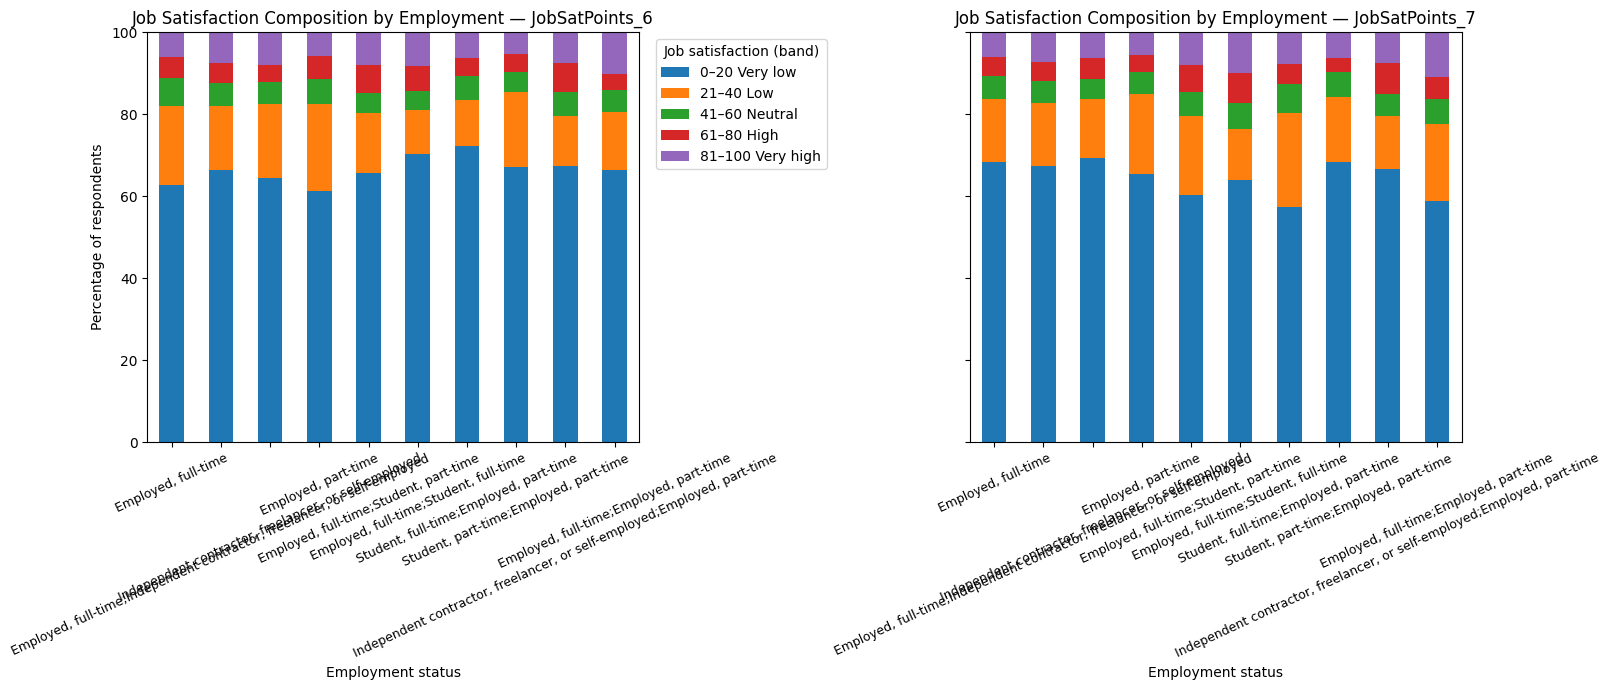

In [24]:
# --- 1) Validate columns -----------------------------------------------------
need_cols = ["Employment", "JobSatPoints_6", "JobSatPoints_7"]
for c in need_cols:
    if c not in df.columns:
        raise KeyError(f"Column '{c}' not found in the dataset.")

# --- 2) Tidy data ------------------------------------------------------------
tidy = (
    df[need_cols]
      .rename(columns={"Employment": "Emp"})
      .copy()
      .melt(id_vars="Emp",
            value_vars=["JobSatPoints_6", "JobSatPoints_7"],
            var_name="Metric", value_name="Score")
)

# Clean
tidy["Emp"] = tidy["Emp"].astype(str).str.strip()
tidy["Score"] = pd.to_numeric(tidy["Score"], errors="coerce")
tidy = tidy.dropna(subset=["Emp", "Score"])

# --- 3) Bin scores for a compact legend -------------------------------------
score_max = tidy["Score"].max()
if score_max <= 10:
    bins   = [0, 2, 4, 6, 8, 10]
    labels = ["0–2 Very low", "3–4 Low", "5–6 Neutral", "7–8 High", "9–10 Very high"]
else:
    bins   = [0, 20, 40, 60, 80, 100]
    labels = ["0–20 Very low", "21–40 Low", "41–60 Neutral", "61–80 High", "81–100 Very high"]

tidy["ScoreBand"] = pd.cut(tidy["Score"], bins=bins, labels=labels, include_lowest=True, right=True)

# --- 4) (Optional) limit to Top-N employment statuses for readability --------
TOP_N = 10
emp_order = (
    tidy.groupby("Emp").size().sort_values(ascending=False).head(TOP_N).index.tolist()
)
tidy = tidy[tidy["Emp"].isin(emp_order)].copy()

# --- 5) Compute % composition by employment for each metric ------------------
dist = (
    tidy.groupby(["Metric", "Emp", "ScoreBand"], observed=True)
        .size().rename("count").reset_index()
)
dist["pct"] = dist["count"] / dist.groupby(["Metric", "Emp"])["count"].transform("sum") * 100
band_order = labels  # keep our chosen order

# --- 6) Plot: two 100% stacked bar charts with one legend --------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

for i, (ax, metric) in enumerate(zip(axes, ["JobSatPoints_6", "JobSatPoints_7"])):
    sub = dist[dist["Metric"] == metric].copy()
    piv = (sub.pivot(index="Emp", columns="ScoreBand", values="pct")
              .reindex(emp_order)
              .reindex(columns=band_order, fill_value=0))
    piv.plot(kind="bar", stacked=True, ax=ax, legend=(i == 0))
    ax.set_title(f"Job Satisfaction Composition by Employment — {metric}")
    ax.set_xlabel("Employment status")
    ax.set_ylabel("Percentage of respondents")
    ax.set_ylim(0, 100)
    ax.tick_params(axis="x", rotation=25, labelsize=9)

# Single shared legend
axes[0].legend(title="Job satisfaction (band)", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


### Task 2: Stacked Chart for Compensation and Job Satisfaction by Age Group


##### This stacked chart visualizes the composition of compensation (`ConvertedCompYearly`) and job satisfaction (`JobSatPoints_6`) specifically for respondents aged 30-35.


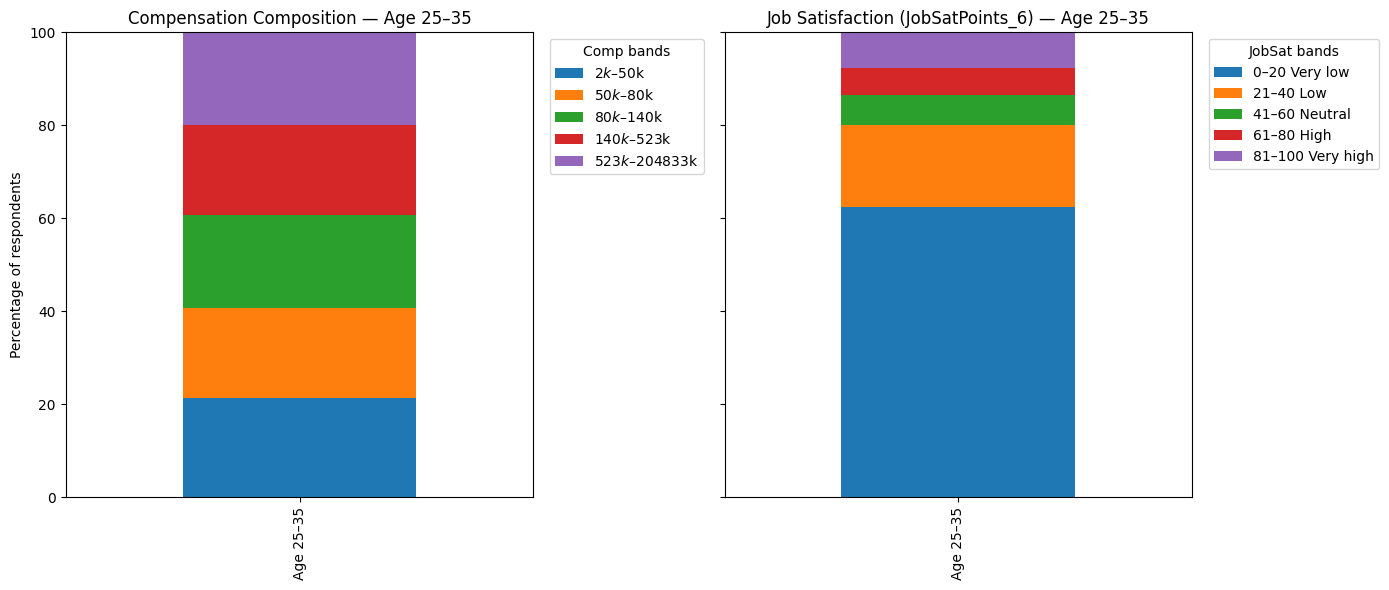

In [26]:
# Assumes: df already loaded and pandas/matplotlib imported.
import numpy as np
import re

# ---------- helpers ----------
def parse_age_to_number(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    v = pd.to_numeric(s, errors="coerce")
    if pd.notna(v): return float(v)
    m = re.search(r'(\d+)\D+(\d+)', s)  # e.g., "30–34 years old"
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0
    if "under" in s and "18" in s: return 16.0
    if ("65" in s and "older" in s) or "65+" in s: return 67.0
    return np.nan

def fmt_money(b):  # e.g., 125000 -> "$125k"
    return f"${int(round(b/1000.0))}k"

# ---------- 0) choose compensation column ----------
cand_cols = [c for c in ["ConvertedCompYearly", "CompTotal"] if c in df.columns]
if not cand_cols:
    raise KeyError("No compensation column found. Expected one of: 'ConvertedCompYearly', 'CompTotal'.")
comp_col = max(cand_cols, key=lambda c: df[c].notna().sum())  # pick the one with most data

# ---------- 1) age selection with graceful fallback ----------
df["Age_num"] = df["Age"].apply(parse_age_to_number)

age_windows = [(30, 35), (25, 35), (25, 40)]  # progressively widen if too few values
chosen_label = None
chosen_sub = None

for lo_a, hi_a in age_windows:
    tmp = df[(df["Age_num"] >= lo_a) & (df["Age_num"] <= hi_a)].copy()
    comp_series = pd.to_numeric(tmp[comp_col], errors="coerce")
    comp_ok = comp_series.gt(0).sum()
    js_ok = pd.to_numeric(tmp["JobSatPoints_6"], errors="coerce").notna().sum()

    if comp_ok >= 5 and js_ok >= 5:  # enough data for both
        chosen_sub = tmp
        chosen_label = f"Age {lo_a}–{hi_a}"
        break

# If still not enough, use the best window by availability; else all ages
if chosen_sub is None:
    # pick the window with the most overlapping valid points
    best_score, best_tmp, best_label = -1, None, None
    for lo_a, hi_a in age_windows:
        tmp = df[(df["Age_num"] >= lo_a) & (df["Age_num"] <= hi_a)].copy()
        comp_ok = pd.to_numeric(tmp[comp_col], errors="coerce").gt(0).sum()
        js_ok = pd.to_numeric(tmp["JobSatPoints_6"], errors="coerce").notna().sum()
        score = min(comp_ok, js_ok)
        if score > best_score:
            best_score, best_tmp, best_label = score, tmp, f"Age {lo_a}–{hi_a}"
    if best_score > 0:
        chosen_sub, chosen_label = best_tmp, best_label + " (widened)"
    else:
        # ultimate fallback: all ages
        chosen_sub, chosen_label = df.copy(), "All ages (fallback; 30–35 had no usable data)"

# ---------- 2) compensation composition ----------
comp = pd.to_numeric(chosen_sub[comp_col], errors="coerce")
comp = comp[comp > 0].dropna()
if comp.empty:
    raise ValueError(f"No valid compensation values found in selected slice: {chosen_label}")

# clip outliers and try quantile bands first
lo, hi = comp.quantile([0.01, 0.99])
comp_clip = comp.clip(lo, hi)
try:
    comp_bins = pd.qcut(comp_clip, q=5, duplicates="drop")
    comp_pct = (comp_bins.value_counts(sort=False, normalize=True) * 100)
    comp_labels = [f"{fmt_money(iv.left)}–{fmt_money(iv.right)}" for iv in comp_bins.cat.categories]
    comp_pct.index = comp_labels
except Exception:
    # fixed-width fallback
    bins = np.linspace(comp_clip.min(), comp_clip.max(), 6)
    comp_bins = pd.cut(comp_clip, bins=bins, include_lowest=True)
    comp_pct = (comp_bins.value_counts(sort=False, normalize=True) * 100)
    comp_labels = [f"{fmt_money(iv.left)}–{fmt_money(iv.right)}" for iv in comp_bins.cat.categories]
    comp_pct.index = comp_labels

comp_comp_df = pd.DataFrame([comp_pct.values], columns=comp_pct.index, index=[chosen_label])

# ---------- 3) JobSatPoints_6 composition ----------
js = pd.to_numeric(chosen_sub["JobSatPoints_6"], errors="coerce").dropna()
if js.empty:
    raise ValueError(f"No valid JobSatPoints_6 values found in selected slice: {chosen_label}")

if js.max() <= 10:
    js_bins   = [0, 2, 4, 6, 8, 10]
    js_labels = ["0–2 Very low", "3–4 Low", "5–6 Neutral", "7–8 High", "9–10 Very high"]
else:
    js_bins   = [0, 20, 40, 60, 80, 100]
    js_labels = ["0–20 Very low", "21–40 Low", "41–60 Neutral", "61–80 High", "81–100 Very high"]

js_band = pd.cut(js, bins=js_bins, labels=js_labels, include_lowest=True, right=True)
js_pct  = (js_band.value_counts(sort=False, normalize=True) * 100)
js_comp_df = pd.DataFrame([js_pct.values], columns=js_labels, index=[chosen_label])

# ---------- 4) plot: two 100% stacked bars ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# comp
comp_comp_df.plot(kind="bar", stacked=True, ax=axes[0], legend=True)
axes[0].set_title(f"Compensation Composition — {chosen_label}")
axes[0].set_xlabel("")
axes[0].set_ylabel("Percentage of respondents")
axes[0].set_ylim(0, 100)
axes[0].legend(title="Comp bands", bbox_to_anchor=(1.02, 1), loc="upper left")

# jobsat
js_comp_df.plot(kind="bar", stacked=True, ax=axes[1], legend=True)
axes[1].set_title(f"Job Satisfaction (JobSatPoints_6) — {chosen_label}")
axes[1].set_xlabel("")
axes[1].set_ylim(0, 100)
axes[1].legend(title="JobSat bands", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


##### Stacked Chart of Median Compensation and Job Satisfaction Across Age Group


Compare the median compensation and job satisfaction metrics across different age groups. This helps visualize how compensation and satisfaction levels differ by age.


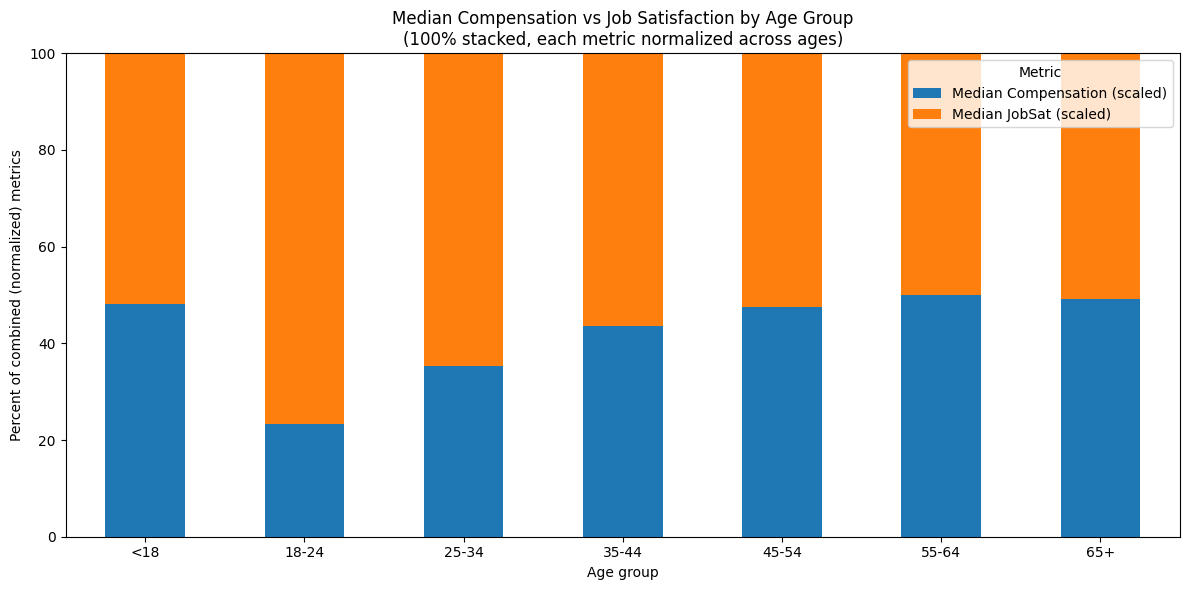

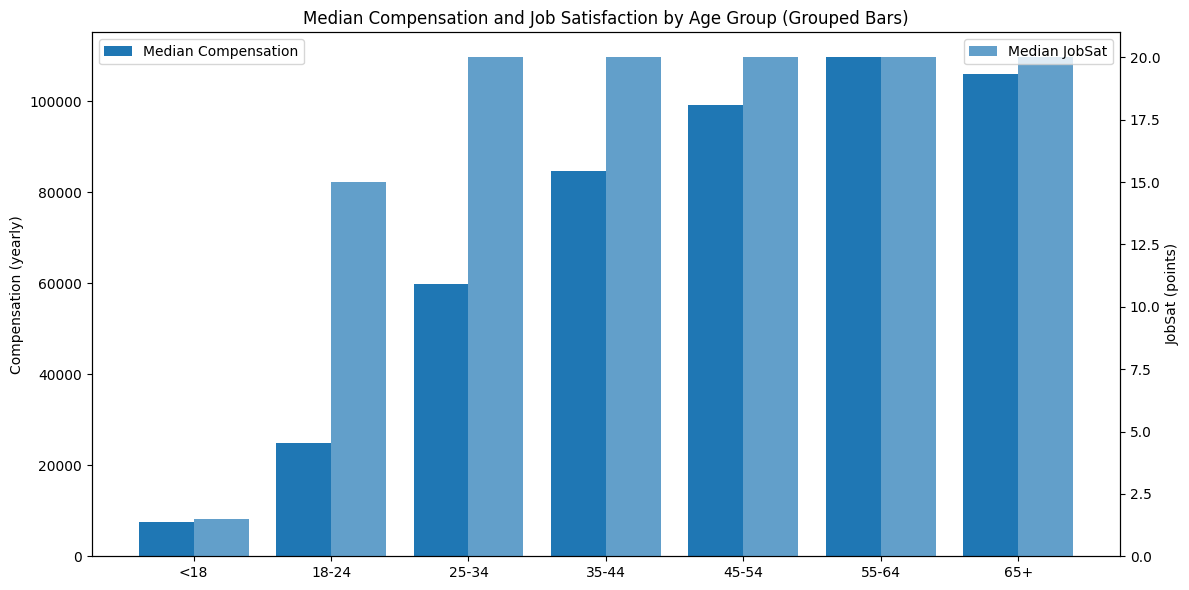

In [28]:

# --- 1) Age → groups ---------------------------------------------------------
import numpy as np
import re

age_bins   = [0, 18, 25, 35, 45, 55, 65, 120]
age_labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

def parse_age_to_number(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    v = pd.to_numeric(s, errors="coerce")
    if pd.notna(v): return float(v)
    m = re.search(r'(\d+)\D+(\d+)', s)  # e.g., "18-24 years old"
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0
    if "under" in s and "18" in s: return 16.0
    if ("65" in s and "older" in s) or "65+" in s: return 67.0
    return np.nan

need_cols = ["Age", "ConvertedCompYearly", "JobSatPoints_6"]
for c in need_cols:
    if c not in df.columns:
        raise KeyError(f"Column '{c}' not found in the dataset.")

df["Age_num"]  = df["Age"].apply(parse_age_to_number)
df["AgeGroup"] = pd.cut(df["Age_num"], bins=age_bins, labels=age_labels, right=False, include_lowest=True)

# --- 2) Medians per age group ------------------------------------------------
comp = pd.to_numeric(df["ConvertedCompYearly"], errors="coerce")
jobs = pd.to_numeric(df["JobSatPoints_6"], errors="coerce")

med = (
    pd.DataFrame({"AgeGroup": df["AgeGroup"], "Comp": comp, "JobSat": jobs})
      .dropna(subset=["AgeGroup"])
      .groupby("AgeGroup", observed=True)
      .median(numeric_only=True)
      .reindex(age_labels)  # keep logical order
)

# If a group has no data for both metrics, drop it to avoid NaNs in plotting
med = med.dropna(how="all")

# --- 3) Normalized 100% stacked view (so the two metrics can be stacked) -----
# Step 1: scale each metric across ALL age groups to [0,1] by its max
norm = pd.DataFrame({
    "Comp_norm":   med["Comp"]   / med["Comp"].max()   if med["Comp"].notna().any()   else med["Comp"],
    "JobSat_norm": med["JobSat"] / med["JobSat"].max() if med["JobSat"].notna().any() else med["JobSat"],
}, index=med.index)

# Step 2: convert each row to percentages that sum to 100 (for stacked bars)
row_sums = norm.sum(axis=1).replace(0, np.nan)
norm_pct = norm.div(row_sums, axis=0) * 100

# --- 4) Plot: Stacked chart of normalized medians ----------------------------
ax = norm_pct.rename(columns={"Comp_norm":"Median Compensation (scaled)",
                              "JobSat_norm":"Median JobSat (scaled)"}).plot(
    kind="bar", stacked=True, figsize=(12, 6), legend=True
)

ax.set_title("Median Compensation vs Job Satisfaction by Age Group\n(100% stacked, each metric normalized across ages)")
ax.set_xlabel("Age group")
ax.set_ylabel("Percent of combined (normalized) metrics")
ax.set_ylim(0, 100)
ax.legend(title="Metric")
ax.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.show()

# --- Optional: also show the raw medians side-by-side (uncomment to use) -----
fig, ax1 = plt.subplots(figsize=(12,6))
width = 0.4
x = np.arange(len(med.index))
ax1.bar(x - width/2, med["Comp"], width=width, label="Median Compensation")
ax1.set_ylabel("Compensation (yearly)")
ax1.set_xticks(x); ax1.set_xticklabels(med.index)
ax2 = ax1.twinx()
ax2.bar(x + width/2, med["JobSat"], width=width, label="Median JobSat", alpha=0.7)
ax2.set_ylabel("JobSat (points)")
ax1.set_title("Median Compensation and Job Satisfaction by Age Group (Grouped Bars)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout(); plt.show()


### Task 3: Comparing Data Using Stacked Charts


##### 1. Stacked Chart of Preferred Databases by Age Group




Visualize the top databases that respondents from different age groups wish to learn. Create a stacked chart to show the proportion of each database in each age group.


C:\Users\liyana_bh\AppData\Local\Temp\ipykernel_17932\3807547026.py:64: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts.pivot_table(index="AgeGroup", columns="Database", values="freq", aggfunc="sum")


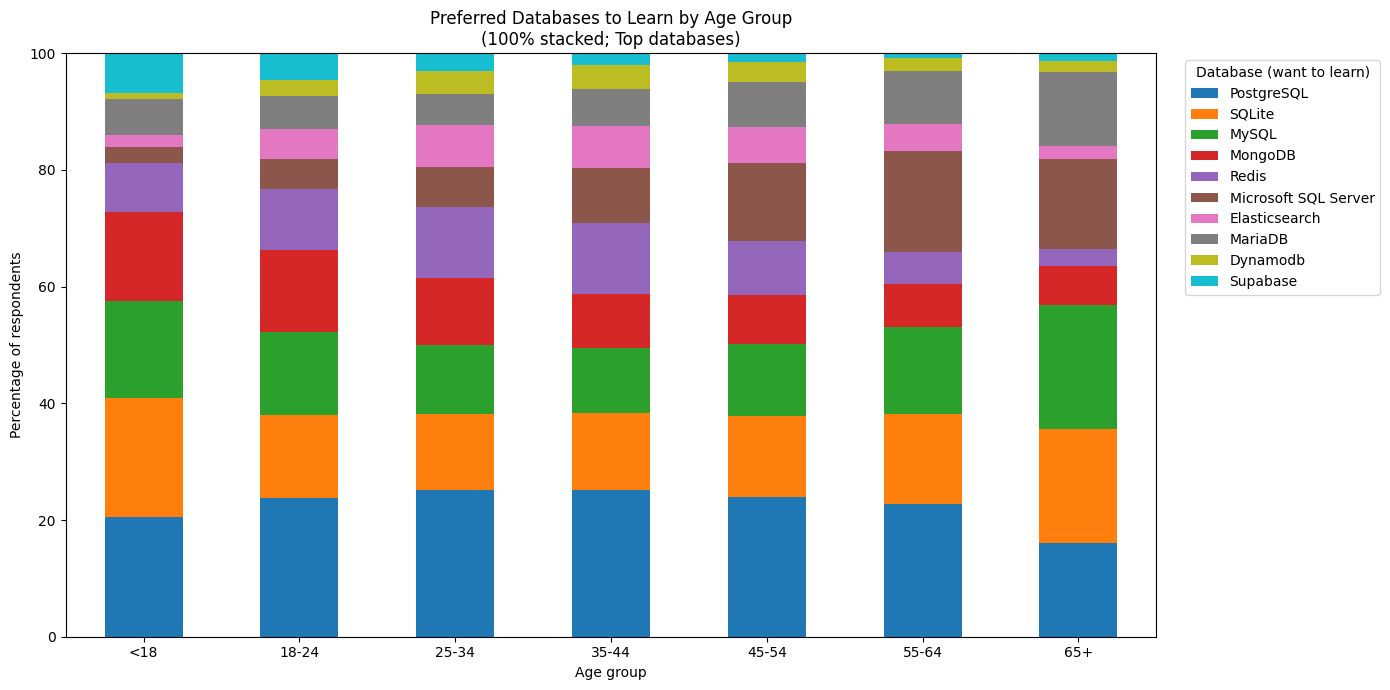

In [30]:
# Assumes: df already loaded and pandas/matplotlib imported.

import numpy as np
import re

db_col = "DatabaseWantToWorkWith"
if db_col not in df.columns:
    raise KeyError(f"Column '{db_col}' not found.")
if "Age" not in df.columns:
    raise KeyError("Column 'Age' not found.")

# --- Age groups ---
age_bins   = [0, 18, 25, 35, 45, 55, 65, 120]
age_labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

def parse_age_to_number(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    v = pd.to_numeric(s, errors="coerce")
    if pd.notna(v): return float(v)
    m = re.search(r'(\d+)\D+(\d+)', s)
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0
    if "under" in s and "18" in s: return 16.0
    if ("65" in s and "older" in s) or "65+" in s: return 67.0
    return np.nan

df["Age_num"]  = df["Age"].apply(parse_age_to_number)
df["AgeGroup"] = pd.cut(df["Age_num"], bins=age_bins, labels=age_labels,
                        right=False, include_lowest=True)

# --- Explode desired databases (FIXED .str.strip) ---
tmp = df[["AgeGroup", db_col]].dropna(subset=["AgeGroup", db_col]).copy()
tmp["Database"] = tmp[db_col].str.split(r";\s*|,\s*", regex=True)
tmp = tmp.explode("Database")

# Convert to string and trim whitespace; drop empties/placeholder strings
tmp["Database"] = tmp["Database"].astype("string").str.strip()
tmp = tmp.dropna(subset=["Database"])
tmp = tmp[~tmp["Database"].isin(["", "NA", "NaN", "None"])]

# --- Count & choose Top-N databases overall ---
counts = (
    tmp.groupby(["AgeGroup", "Database"], observed=True)
       .size()
       .reset_index(name="freq")
)

TOP_N = 10
top_dbs = (
    counts.groupby("Database")["freq"].sum()
          .sort_values(ascending=False)
          .head(TOP_N).index
)
counts = counts[counts["Database"].isin(top_dbs)].copy()

# Order axes
counts["AgeGroup"] = pd.Categorical(counts["AgeGroup"], categories=age_labels, ordered=True)
db_order = counts.groupby("Database")["freq"].sum().sort_values(ascending=False).index.tolist()

# --- Build 100% stacked composition per age group ---
piv = (
    counts.pivot_table(index="AgeGroup", columns="Database", values="freq", aggfunc="sum")
          .reindex(age_labels)
          .reindex(columns=db_order, fill_value=0)
)
row_sums = piv.sum(axis=1).replace(0, np.nan)
piv_pct = (piv.div(row_sums, axis=0) * 100).fillna(0)

# Drop empty age groups (for these Top-N)
piv_pct = piv_pct.loc[piv_pct.sum(axis=1) > 0]

# --- Plot ---
ax = piv_pct.plot(kind="bar", stacked=True, figsize=(14, 7), legend=True)
ax.set_title("Preferred Databases to Learn by Age Group\n(100% stacked; Top databases)")
ax.set_xlabel("Age group")
ax.set_ylabel("Percentage of respondents")
ax.set_ylim(0, 100)
ax.tick_params(axis="x", rotation=0)
ax.legend(title="Database (want to learn)", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


##### 2. Stacked Chart of Employment Type by Job Satisfaction


Analyze the distribution of employment types within each job satisfaction level using a stacked chart. This will provide insights into how employment types are distributed across various satisfaction ratings.


C:\Users\liyana_bh\AppData\Local\Temp\ipykernel_17932\3807547026.py:64: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts.pivot_table(index="AgeGroup", columns="Database", values="freq", aggfunc="sum")


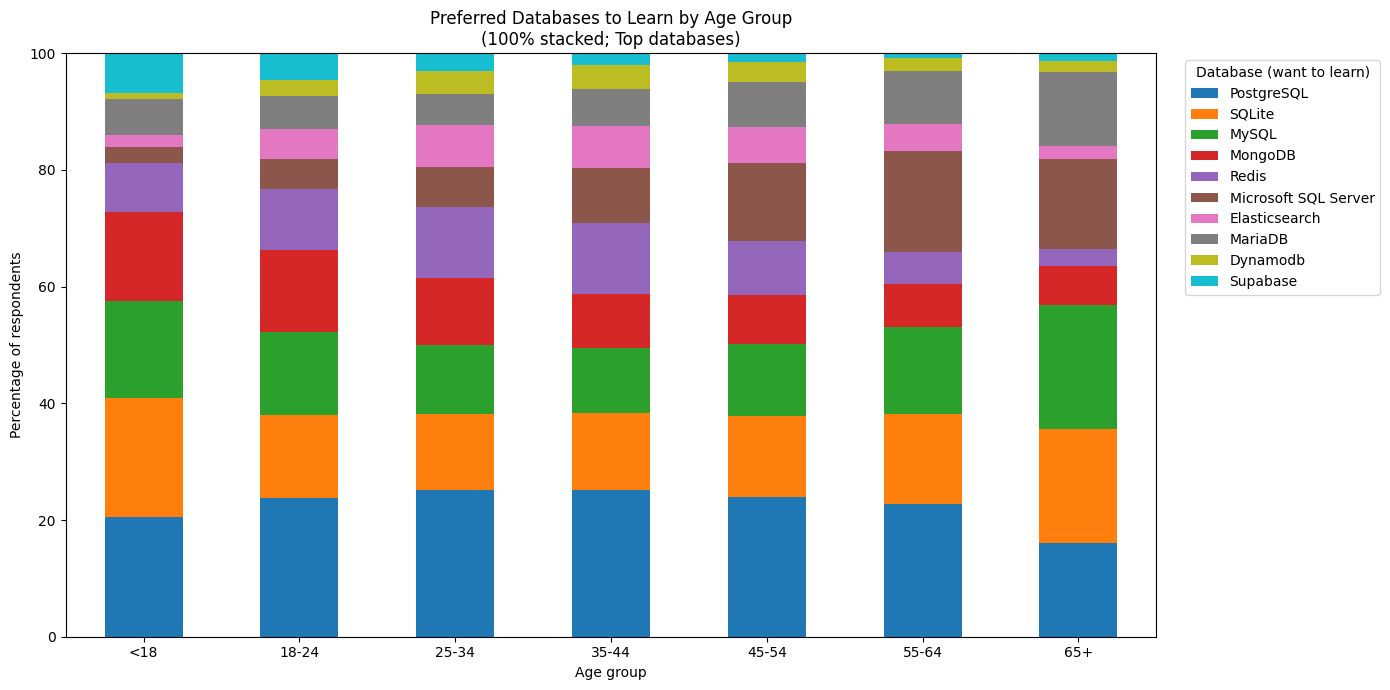

In [31]:
# Assumes: df already loaded and pandas/matplotlib imported.

import numpy as np
import re

db_col = "DatabaseWantToWorkWith"
if db_col not in df.columns:
    raise KeyError(f"Column '{db_col}' not found.")
if "Age" not in df.columns:
    raise KeyError("Column 'Age' not found.")

# --- Age groups ---
age_bins   = [0, 18, 25, 35, 45, 55, 65, 120]
age_labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

def parse_age_to_number(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    v = pd.to_numeric(s, errors="coerce")
    if pd.notna(v): return float(v)
    m = re.search(r'(\d+)\D+(\d+)', s)
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0
    if "under" in s and "18" in s: return 16.0
    if ("65" in s and "older" in s) or "65+" in s: return 67.0
    return np.nan

df["Age_num"]  = df["Age"].apply(parse_age_to_number)
df["AgeGroup"] = pd.cut(df["Age_num"], bins=age_bins, labels=age_labels,
                        right=False, include_lowest=True)

# --- Explode desired databases (FIXED .str.strip) ---
tmp = df[["AgeGroup", db_col]].dropna(subset=["AgeGroup", db_col]).copy()
tmp["Database"] = tmp[db_col].str.split(r";\s*|,\s*", regex=True)
tmp = tmp.explode("Database")

# Convert to string and trim whitespace; drop empties/placeholder strings
tmp["Database"] = tmp["Database"].astype("string").str.strip()
tmp = tmp.dropna(subset=["Database"])
tmp = tmp[~tmp["Database"].isin(["", "NA", "NaN", "None"])]

# --- Count & choose Top-N databases overall ---
counts = (
    tmp.groupby(["AgeGroup", "Database"], observed=True)
       .size()
       .reset_index(name="freq")
)

TOP_N = 10
top_dbs = (
    counts.groupby("Database")["freq"].sum()
          .sort_values(ascending=False)
          .head(TOP_N).index
)
counts = counts[counts["Database"].isin(top_dbs)].copy()

# Order axes
counts["AgeGroup"] = pd.Categorical(counts["AgeGroup"], categories=age_labels, ordered=True)
db_order = counts.groupby("Database")["freq"].sum().sort_values(ascending=False).index.tolist()

# --- Build 100% stacked composition per age group ---
piv = (
    counts.pivot_table(index="AgeGroup", columns="Database", values="freq", aggfunc="sum")
          .reindex(age_labels)
          .reindex(columns=db_order, fill_value=0)
)
row_sums = piv.sum(axis=1).replace(0, np.nan)
piv_pct = (piv.div(row_sums, axis=0) * 100).fillna(0)

# Drop empty age groups (for these Top-N)
piv_pct = piv_pct.loc[piv_pct.sum(axis=1) > 0]

# --- Plot ---
ax = piv_pct.plot(kind="bar", stacked=True, figsize=(14, 7), legend=True)
ax.set_title("Preferred Databases to Learn by Age Group\n(100% stacked; Top databases)")
ax.set_xlabel("Age group")
ax.set_ylabel("Percentage of respondents")
ax.set_ylim(0, 100)
ax.tick_params(axis="x", rotation=0)
ax.legend(title="Database (want to learn)", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


### Task 4: Exploring Technology Preferences Using Stacked Charts


##### 1. Stacked Chart for Preferred Programming Languages by Age Group


Analyze how programming language preferences (`LanguageAdmired`) vary across age groups.


C:\Users\liyana_bh\AppData\Local\Temp\ipykernel_17932\2563871662.py:65: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts.pivot_table(index="AgeGroup", columns="Language", values="freq", aggfunc="sum")


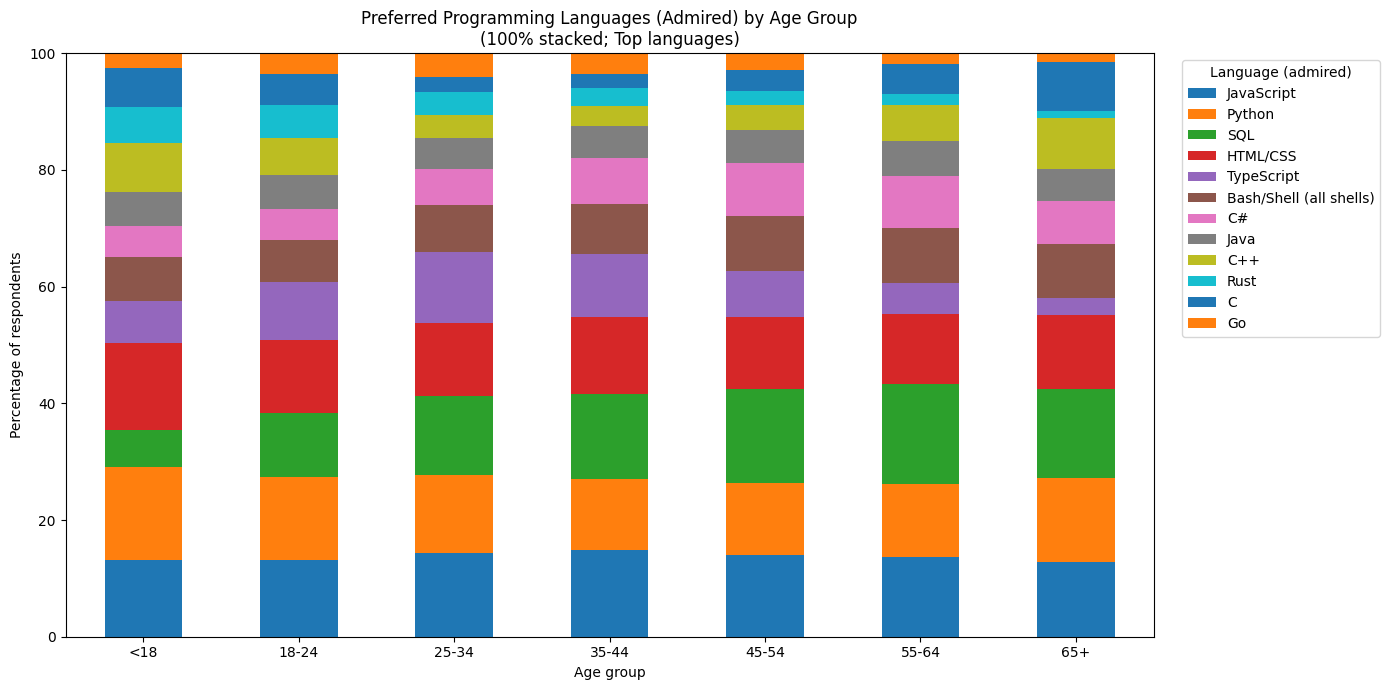

In [32]:
# --- 1) Validate columns -----------------------------------------------------
if "Age" not in df.columns:
    raise KeyError("Column 'Age' not found.")
if "LanguageAdmired" not in df.columns:
    raise KeyError("Column 'LanguageAdmired' not found.")

# --- 2) Build Age groups -----------------------------------------------------
import numpy as np
import re

age_bins   = [0, 18, 25, 35, 45, 55, 65, 120]
age_labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

def parse_age_to_number(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    v = pd.to_numeric(s, errors="coerce")
    if pd.notna(v): return float(v)
    m = re.search(r'(\d+)\D+(\d+)', s)  # handles "18-24 years old"
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0
    if "under" in s and "18" in s: return 16.0
    if ("65" in s and "older" in s) or "65+" in s: return 67.0
    return np.nan

df["Age_num"]  = df["Age"].apply(parse_age_to_number)
df["AgeGroup"] = pd.cut(df["Age_num"], bins=age_bins, labels=age_labels,
                        right=False, include_lowest=True)

# --- 3) Explode admired languages -------------------------------------------
tmp = df[["AgeGroup", "LanguageAdmired"]].dropna(subset=["AgeGroup", "LanguageAdmired"]).copy()

# Split multi-select values and explode to one language per row
tmp["Language"] = tmp["LanguageAdmired"].str.split(r";\s*|,\s*", regex=True)
tmp = tmp.explode("Language")

# Clean strings & drop empties/placeholders
tmp["Language"] = tmp["Language"].astype("string").str.strip()
tmp = tmp.dropna(subset=["Language"])
tmp = tmp[tmp["Language"].ne("")]
tmp = tmp[~tmp["Language"].isin(["NA", "NaN", "None"])]

# --- 4) Count frequencies & pick Top-N languages overall --------------------
counts = (
    tmp.groupby(["AgeGroup", "Language"], observed=True)
       .size()
       .reset_index(name="freq")
)

TOP_N = 12  # change to show more/less stacks
top_langs = (
    counts.groupby("Language")["freq"].sum()
          .sort_values(ascending=False)
          .head(TOP_N).index
)
counts = counts[counts["Language"].isin(top_langs)].copy()

# Keep axis orders tidy
counts["AgeGroup"] = pd.Categorical(counts["AgeGroup"], categories=age_labels, ordered=True)
lang_order = counts.groupby("Language")["freq"].sum().sort_values(ascending=False).index.tolist()

# --- 5) Build 100% stacked composition per age group ------------------------
piv = (
    counts.pivot_table(index="AgeGroup", columns="Language", values="freq", aggfunc="sum")
          .reindex(age_labels)
          .reindex(columns=lang_order, fill_value=0)
)

row_sums = piv.sum(axis=1).replace(0, np.nan)
piv_pct = (piv.div(row_sums, axis=0) * 100).fillna(0)

# Drop age groups with no respondents for these Top-N languages
piv_pct = piv_pct.loc[piv_pct.sum(axis=1) > 0]

# --- 6) Plot: 100% stacked bar chart ----------------------------------------
ax = piv_pct.plot(kind="bar", stacked=True, figsize=(14, 7), legend=True)

ax.set_title("Preferred Programming Languages (Admired) by Age Group\n(100% stacked; Top languages)")
ax.set_xlabel("Age group")
ax.set_ylabel("Percentage of respondents")
ax.set_ylim(0, 100)
ax.tick_params(axis="x", rotation=0)
ax.legend(title="Language (admired)", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


##### 2. Stacked Chart for Technology Adoption by Employment Type


Explore how admired platforms (`PlatformAdmired`) differ across employment types (e.g., full-time, freelance)


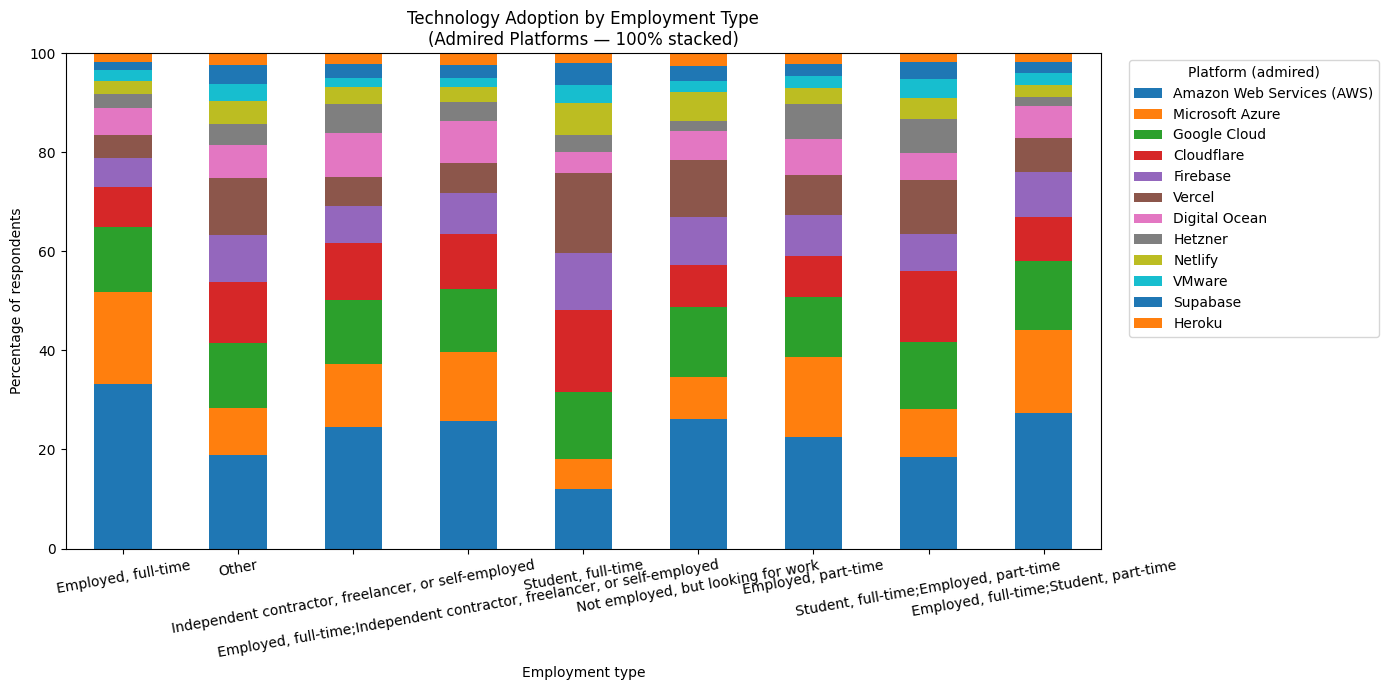

In [33]:
# --- 1) Validate columns -----------------------------------------------------
if "Employment" not in df.columns:
    raise KeyError("Column 'Employment' not found.")
if "PlatformAdmired" not in df.columns:
    raise KeyError("Column 'PlatformAdmired' not found.")

# --- 2) Clean employment & explode admired platforms ------------------------
tmp = df[["Employment", "PlatformAdmired"]].dropna(subset=["Employment", "PlatformAdmired"]).copy()

# Normalize employment labels a bit
tmp["Employment"] = tmp["Employment"].astype("string").str.strip()

# Split multi-select values and explode to one platform per row
tmp["Platform"] = tmp["PlatformAdmired"].str.split(r";\s*|,\s*", regex=True)
tmp = tmp.explode("Platform")

# Clean platform strings; drop empties/placeholders
tmp["Platform"] = tmp["Platform"].astype("string").str.strip()
tmp = tmp.dropna(subset=["Platform"])
tmp = tmp[tmp["Platform"].ne("")]
tmp = tmp[~tmp["Platform"].isin(["NA", "NaN", "None"])]

# --- 3) Limit employment categories (optional) ------------------------------
TOP_EMP = 8  # keep most common employment types; others -> 'Other'
emp_counts = tmp["Employment"].value_counts()
top_emp = emp_counts.head(TOP_EMP).index.tolist()
tmp["Employment_slim"] = tmp["Employment"].where(tmp["Employment"].isin(top_emp), other="Other")

# Order employment by size
emp_order = (
    tmp["Employment_slim"].value_counts()
      .sort_values(ascending=False)
      .index.tolist()
)

# --- 4) Count platforms and keep Top-N overall ------------------------------
counts = (
    tmp.groupby(["Employment_slim", "Platform"], observed=True)
       .size()
       .reset_index(name="freq")
)

TOP_PLAT = 12  # adjust for more/less stacks
top_platforms = (
    counts.groupby("Platform")["freq"].sum()
          .sort_values(ascending=False)
          .head(TOP_PLAT).index
)
counts = counts[counts["Platform"].isin(top_platforms)].copy()

# Platform order by overall share
plat_order = (
    counts.groupby("Platform")["freq"].sum()
          .sort_values(ascending=False)
          .index.tolist()
)

# --- 5) Build 100% stacked composition per employment type ------------------
piv = (
    counts.pivot_table(index="Employment_slim", columns="Platform", values="freq", aggfunc="sum")
          .reindex(emp_order)
          .reindex(columns=plat_order, fill_value=0)
)

row_sums = piv.sum(axis=1).replace(0, float("nan"))
piv_pct = (piv.div(row_sums, axis=0) * 100).fillna(0)

# Drop empty rows (if any)
piv_pct = piv_pct.loc[piv_pct.sum(axis=1) > 0]

# --- 6) Plot: 100% stacked bar chart ----------------------------------------
ax = piv_pct.plot(kind="bar", stacked=True, figsize=(14, 7), legend=True)

ax.set_title("Technology Adoption by Employment Type\n(Admired Platforms — 100% stacked)")
ax.set_xlabel("Employment type")
ax.set_ylabel("Percentage of respondents")
ax.set_ylim(0, 100)
ax.tick_params(axis="x", rotation=10)

# Move legend outside for readability
ax.legend(title="Platform (admired)", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


### Final Step: Review


In this lab, you focused on using stacked charts to understand the composition and comparison within the dataset. Stacked charts provided insights into job satisfaction, compensation, and preferred databases across age groups and employment types.


-Review
In this lab, I used stacked charts to analyze composition and compare segments across the dataset. I cleaned and grouped key fields (Age groups, Employment types) and exploded multi-select columns (e.g., databases, platforms). Stacked bars revealed how job satisfaction and compensation bands vary by age, and how preferred databases/platforms differ across both age groups and employment types. Converting scores to common bands (e.g., very low → very high) made the legends compact and comparisons clear. Normalizing to 100% stacks highlighted proportions, not raw counts, enabling fair comparisons between groups of different sizes.

-Key insights
Younger vs. mid-career groups show different mixes of satisfaction and compensation bands.
Certain employment types cluster in higher satisfaction bands; others skew neutral/low.
Preferred databases and platforms differ by age and employment, indicating distinct learning/adoption priorities.

-Limitations
Self-reported data, uneven sample sizes across segments, and collapsed bands can hide within-group variance.

-Next steps
Add confidence intervals, show raw counts alongside percentages, test differences statistically, and consider interactive dashboards for drill-downs.

## Summary


After completing this lab, you will be able to:

- Use stacked charts to analyze the composition of data across categories, such as job satisfaction and compensation by age group.

- Compare data across different dimensions using stacked charts, enhancing your ability to communicate complex relationships in the data.

- Visualize distributions across multiple categories, such as employment type by satisfaction, to gain a deeper understanding of patterns within the dataset.


## Author:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--
## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2024-10-28|1.2|Madhusudhan Moole|Updated lab|
|2024-10-16|1.1|Madhusudhan Moole|Updated lab|
|2024-10-15|1.0|Raghul Ramesh|Created lab|
--!>


Copyright © IBM Corporation. All rights reserved.
